# Information diffusion on X (formerly Twitter): a model comparison approach

This notebook is the accompanying code of my master's thesis project. You can find the manuscript on my Github in .tex and .pdf formats.

Author: Ekin Derdiyok

Email: ekin.derdiyok@icloud.com

Github: https://github.com/ekinderdiyok/information-diffusion-on-twitter

Affiliation: M.Sc. in Cognitive Neuroscience (MCNB), Fachbereich Erziehungswissenschaft und Psychologie, Freie Universität Berlin

Date: April 1, 2024

Versions used in this study: <br>
Python version: 3.9.13 (main, Aug 25 2022, 18:24:45) [Clang 12.0.0 ] <br>
Pandas version: 1.4.4 <br>
Matplotlib version: 3.8.2 <br>
NumPy version: 1.21.5 <br>
NetworkX version: 2.8.4 <br>
Seaborn version: 0.11.2 <br>
OpenAI version: 0.28.0 <br>
sklearn version: 1.1.1 <br>
SciPy version: 1.9.1 <br>

## Table of contents
1. [Import, check versions, preprocess](#import)
5. [Explore](#explore)
5. [Modeling retweet count](#modeling-retweet-count)
    1. [Null model](#null-model)
    1. [Mean-field model](#mean-field-models)
    2. [SI Model](#si-model)
    3. [IC Model](#ic-model)
    4. [Decaying IC Model](#decaying-ic-model)
6. [Time series analysis](#time-series-analysis)
    1. [ECDF](#ecdf)
    4. [ECDF vs Decaying IC](#ecdf-vs-dec-IC)
    2. [Avrami equation](#avrami-equation)
    4. [Logarithmic fit](#log-fit)
8. [Interrater agreement](#interrater-agreement)
    1. [Topic](#topic)
    2. [Semantic Category](#sem-cat)
    
    


## Import, check versions, preprocess

In [1]:
from functions import * # Imports my custom functions

# Print versions of libraries
print(f'You are currently using the following versions:')
print(f'Python version: 3.9.13 (main, Aug 25 2022, 18:24:45) [Clang 12.0.0 ]')
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("NumPy version:", np.__version__)
print("NetworkX version:", nx.__version__)
print("Seaborn version:", sns.__version__)
print("OpenAI version:", openai.__version__)
print("sklearn version:", sklearn.__version__)
print("SciPy version:", scipy.__version__)

# Use less ink for plots and match the LaTeX default font for beautiful plots
set_plot_style()

# Preprocess the data to create 'cascades' dataframe
cascades, fn, groups = preprocess_data()

You are currently using the following versions:
Python version: 3.9.13 (main, Aug 25 2022, 18:24:45) [Clang 12.0.0 ]
Pandas version: 1.4.4
Matplotlib version: 3.8.2
NumPy version: 1.21.5
NetworkX version: 2.8.4
Seaborn version: 0.11.2
OpenAI version: 0.28.0
sklearn version: 1.1.1
SciPy version: 1.9.1


## Explore  <a class="anchor" id="explore"></a>

In [2]:
print(print_start_end(cascades),'\n')
print(cascades.topic.value_counts())

print("\n")

#Inspect a randomly picked graph
tweet_id = pick_random_tweet_id(cascades)
G = create_G(data = cascades, tweet_id = tweet_id, fn = fn)
inspect_G(cascades = cascades, G = G, tweet_id = tweet_id)

print("\n")

# Compare infectiousness across semantic categories
print(cascades.groupby('natures')['n_rts_norm'].mean())

print("\n")

print(cascades['natures'].value_counts())

Earliest date: 2015-04-25 04:23:59
Latest date: 2015-04-27 03:21:56
None 

7. Relief efforts, resources, donations, and infrastructure    229
2. Impact, aftermath, death toll                                98
4. International response and international support             79
6. Controversy, criticism, social and political commentary      58
1. Rescue operations and assistance                             30
8. Faith and prayers                                            30
9. Personal experience, stories, and missing people             27
3. Aftershocks and tremors                                      23
5. Technology, communication, and social media                  19
The tweet does not fit any of the given topics.                 12
Name: topic, dtype: int64


Randomly chosen tweet_id is: '592281615440617473'
The number of nodes in graph G are 1917
The number of edges in graph G are 2430
The number of retweets is 12
Out-degree of the original poster: 722
In-degree of the original pos

In [2]:
# Define categories
n_rts_fact = cascades[cascades['natures'] == 0]['n_rts']
n_rts_emot = cascades[cascades['natures'] == 1]['n_rts']

# Run t-test and print
ttest_cats(n_rts_fact, n_rts_emot, alpha = 0.05)

print('\n')

# Define categories
norm_fact = cascades[cascades['natures'] == 0]['n_rts_norm']
norm_emot = cascades[cascades['natures'] == 1]['n_rts_norm']

# Run t-test and print
ttest_cats(norm_fact, norm_emot, alpha = 0.05)

Fail to reject the null hypothesis: There is no significant difference between the two categories.
T-Statistic: 1.6369328264119212
Degrees of Freedom: 296
P-Value: 0.10217504772148811


Reject the null hypothesis: There is a significant difference between the two categories.
T-Statistic: -1.9651759175240293
Degrees of Freedom: 296
P-Value: 0.04986023571908984


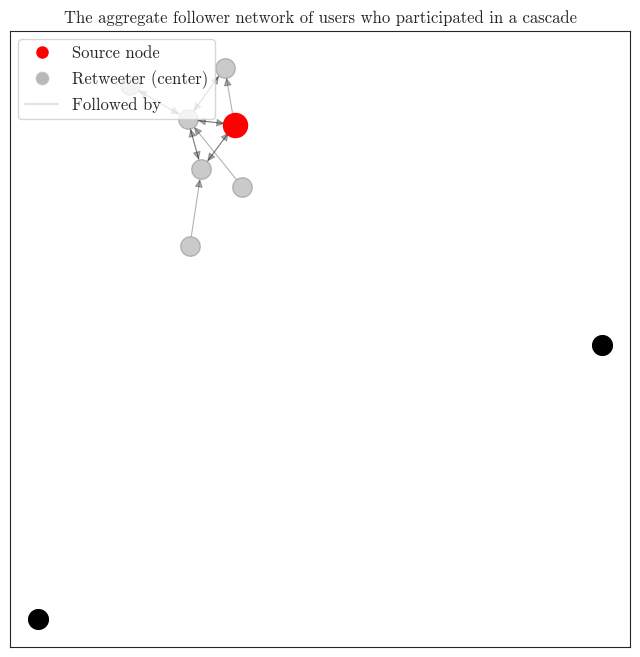

In [32]:
tweet_id = '592275479916220416'
#tweet_id = '592602977656971264' other figures in the paper
#tweet_id = '591905536641110016' other figures in the paper
#tweet_id = '591934338540838913' other figures in the paper
#tweet_id = '592349909136846848' other figures in the paper
#tweet_id = '592397370018570240' other figures in the paper
#tweet_id = '592200963483533312' other figures in the paper

plot_rt_network(cascades, tweet_id, fn, pct_exc = 1, only_rt = False)

## Modeling retweet count  <a class="anchor" id="modeling-retweet-count"></a>

### Null model  <a class="anchor" id="null-model"></a>

In [23]:
# Fit

# Define X and y
X = cascades['n_network_followers'].values.reshape(-1, 1)
y = cascades['n_rts']

# Fit model
model, mad, pearson_corr, p = fit_null_model(X, y)

# Evaluate
print(f'Mean absolute deviation: {mad}')
print(f'Pearson\'s correlation: {pearson_corr}')
print(f'p value is: {p}')
print(f'slope is : {model.coef_}')
print(f'intercept is : {model.intercept_}')

Mean absolute deviation: 31.15811830438228
Pearson's correlation: 0.13092908849317936
p value is: 0.0012480115167486042
slope is : [0.00209551]
intercept is : 30.4146693619734


/Users/ekinderdiyok/opt/anaconda3/lib/python3.9/site-packages/seaborn/regression.py:858: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


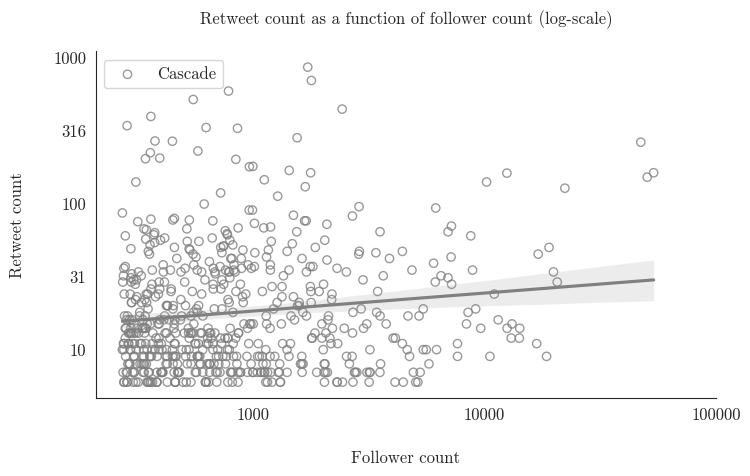

In [4]:
# Plot

# Close any previous figure to avoid interference
plt.close()

# Set the figure size to 16:9 aspect ratio
plt.figure(figsize=(16/2, 9/2))

# Scatterplot 
g = sns.regplot(x=np.log10(cascades.n_network_followers), y=np.log10(cascades.n_rts), scatter_kws={'edgecolor': 'gray', 'facecolor': 'None'},color='gray',ci=95)

# Add labels and title to the plot, remove top and right borders
plt.xlabel('Follower count',labelpad=20)
plt.ylabel('Retweet count',labelpad=20)
plt.title('Retweet count as a function of follower count (log-scale)',pad=20)
plt.legend(['Cascade'],loc='upper left')
sns.despine()

# Format axes ticks
g.set_xticks([3, 4, 5])
g.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(10**x)))
g.yaxis.set_major_formatter(FuncFormatter(lambda y, _: int(10**y)))


# Save the plot as an SVG and PNG file
#plt.savefig(fig_path + 'linreg_plot.svg', format='svg', bbox_inches='tight')
#plt.savefig(fig_path + 'linreg_plot.png', format='png', bbox_inches='tight', dpi=300)

/Users/ekinderdiyok/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3381: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


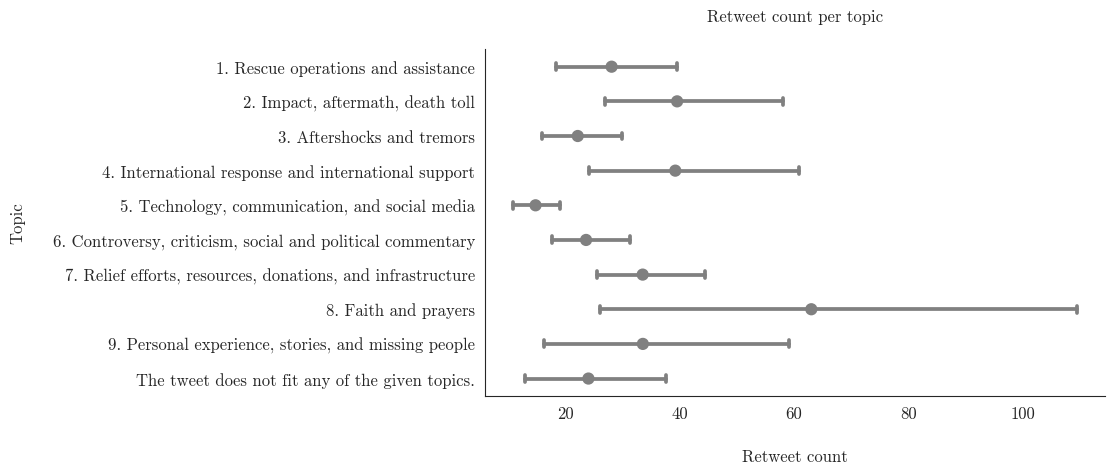

ANOVA Table:
F-statistic: 1.0787471473023063
P-value: 0.3764259530899824
Between-group degrees of freedom: 9
Within-group degrees of freedom: 595


In [5]:
##### RETWEET COUNT PER TOPIC #####
plt.close()
plt.figure(figsize=(16/2, 9/2))
sns.pointplot(y='topic', x='n_rts', data=cascades, errorbar = 'std', capsize=0.2, join=False, dodge=True,color='gray')
plt.title('Retweet count per topic',pad=20)
plt.xlabel('Retweet count',labelpad=20)
plt.ylabel('Topic',labelpad=20)
sns.despine()
# Save the plot as an SVG file
#plt.savefig('/Users/ekinderdiyok/Documents/Thesis/Figures/topic_comp_n_rt_plot.svg', format='svg', bbox_inches='tight')
plt.show()

# Calculate degrees of freedom
num_groups = len(cascades.topic.unique())
total_observations = len(cascades)

df_between = num_groups - 1
df_within = total_observations - num_groups

# ANOVA analysis
anova_result = f_oneway(*[cascades['n_rts'][cascades['topic'] == topic] for topic in cascades['topic'].unique()])

# Print ANOVA table
print("ANOVA Table:")
print("F-statistic:", anova_result.statistic)
print("P-value:", anova_result.pvalue)
print("Between-group degrees of freedom:", df_between)
print("Within-group degrees of freedom:", df_within)

### Mean-field models <a class="anchor" id="mean-field-models"></a>

In [6]:
##### SIMULATE #####
beta = 0.0003
tweet_id = pick_random_tweet_id(cascades)
n_iter = 2
sim, obs = simulate_base_SI(cascades, beta, tweet_id, n_iter = n_iter)
print(f'sim: {sim}')
print(f'obs: {obs}')

Randomly chosen tweet_id is: '592239004579270656'
sim: 1.0
obs: 11


Estimated beta value is: 3.301066822117917e-05
Model mean absolute deviation is: 32.47107438016529
Pearson's correlation coefficient: 0.1540268084227332
P-value: 0.000142698713937663


/Users/ekinderdiyok/Documents/Thesis/Code/functions.py:190: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.scatter(obss, sims, marker='o', facecolors='None', edgecolors='gray', label = 'Cascade')


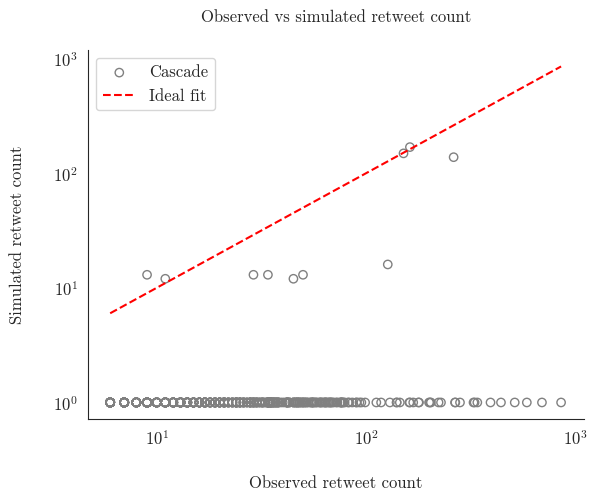

In [2]:
##### FIT, EVALUATE, ESTIMATE #####
result = fit_base_SI(cascades, n_iter = 5)
est_beta = result.x
print(f'Estimated beta value is: {est_beta}')

mse, corr_coef, _, _ = eval_model(simulate_base_SI, est_beta, cascades, n_iter = 5, fn = fn)

### SI Model <a class="anchor" id="si-model"></a>

In [5]:
# Simulate
tweet_id = pick_random_tweet_id(cascades)
G = create_G(cascades, tweet_id, fn)
n_iter = 5 # iter_0 is the initial state with zero infected, iter_1 is only source node infected, hence n_iter makes sense 2 onwards.
beta = 0.0011
sim, obs = simulate_SI(cascades, G, beta, tweet_id, n_iter)
print(f'simulated number of retweets: {sim}')
print(f'observed number of retweets: {obs}')

Randomly chosen tweet_id is: '592349941164453888'
simulated number of retweets: 2
observed number of retweets: 9


In [2]:
# Fit
beta_SI = fit_SI(data = cascades, n_iter = 5, fn = fn)
print(f'Beta estimate of the SI model is: {beta_SI}') # 0.0011351624193084292 or 0.0010706769908942336

Beta estimate of the SI model is: 0.0010435467533791607


Model mean absolute deviation is: 29.58512396694215
Pearson's correlation coefficient: 0.13520095722649106
P-value: 0.0008562324105799674


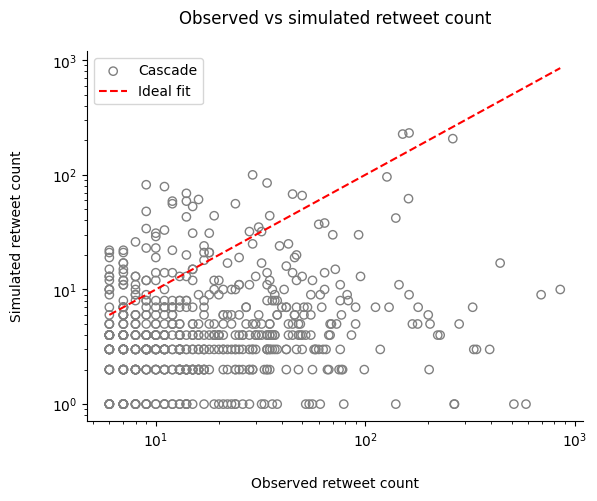

In [40]:
# Evaluate
mad, r, _, _ = eval_model(simulate_SI, 0.00107, cascades, n_iter = 5, fn = fn, k = None)

### IC Model <a class="anchor" id="ic-model"></a>

In [34]:
# Simulate
threshold = 0.005
tweet_id = pick_random_tweet_id(cascades)
G = create_G(cascades, tweet_id, fn)
sim, obs =  simulate_IC(cascades, G, threshold, tweet_id, n_iter=5)
print(f'Simulated number of retweets: {sim}')
print(f'Observed number of retweets: {obs}')

Randomly chosen tweet_id is: '592352396593926144'
Simulated number of retweets: 5
Observed number of retweets: 6


In [4]:
# Fit
threshold_IC = fit_IC(cascades, n_iter = 5, fn = fn)
print(f'Threshold estimate of the IC model is: {threshold_IC}')

Threshold estimate of the IC model is: 0.004641039371822543


Model mean absolute deviation is: 29.760330578512395
Pearson's correlation coefficient: 0.13662592581648686
P-value: 0.0007532761601895288


/Users/ekinderdiyok/Documents/Thesis/Code/functions.py:190: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.scatter(obss, sims, marker='o', facecolors='None', edgecolors='gray', label = 'Cascade')


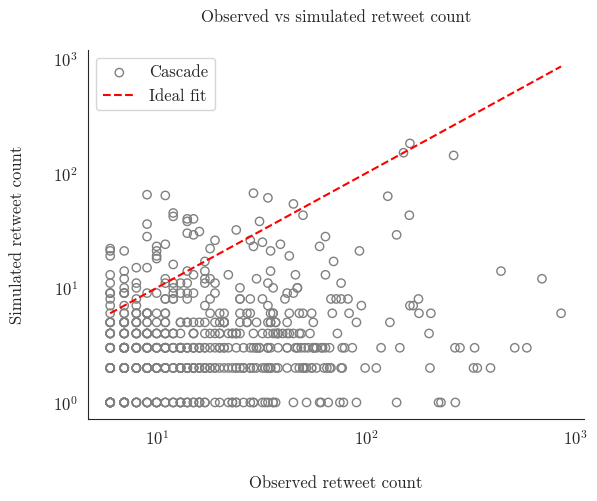

In [5]:
# Evaluate
mse, r2, _, _ = eval_model(simulate_IC, param = threshold_IC, data = cascades, n_iter = 5, fn = fn)

In [6]:
# Evaluate (topicwise)
thresholds_IC = {}
sem_cat_groups = split_dataframe_by_category(cascades, 'topic')
for topic, group in groups.items():
    threshold = fit_IC(data = group, n_iter = 5, fn = fn)
    thresholds_IC[topic] = (threshold, len(group))

/var/folders/j6/6k9fmtb55kj1jy3rcgmt4c4h0000gn/T/ipykernel_1437/3564390565.py:7: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


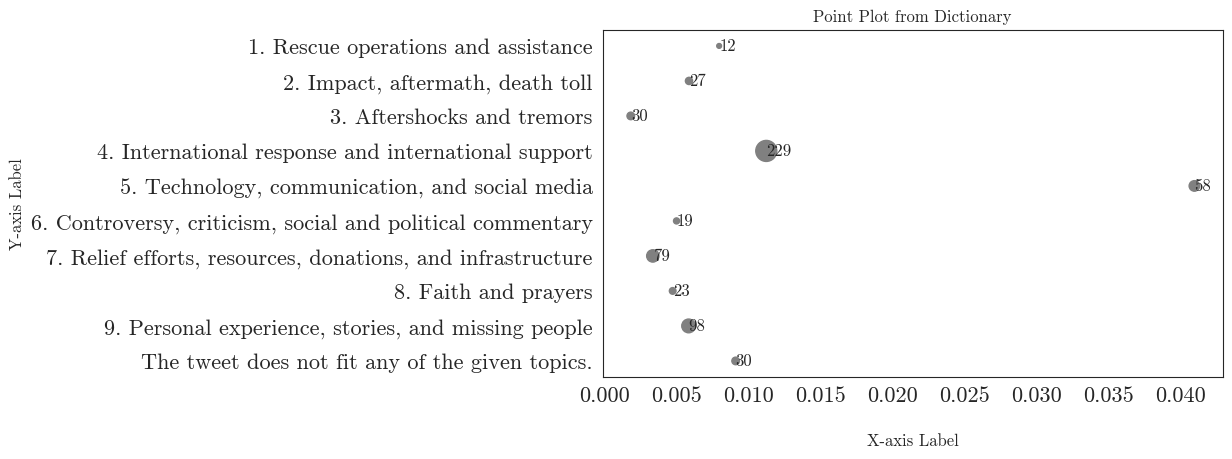

In [14]:
# Plot
plot_param_dicts(param_dicts = thresholds_IC)

In [16]:
# Evaluate (sematic category-wise)
thresholds_IC = {}
sem_cat_groups = split_dataframe_by_category(cascades, 'natures')
for sem_cat, group in sem_cat_groups.items():
    threshold = fit_IC(data = group, n_iter = 5, fn = fn)
    thresholds_IC[sem_cat] = (threshold, len(group))

'{0: (0.004830439502094972, 396),\n 1: (0.0036913726414133214, 199),\n 2: (0.009305472654999364, 10)}'

/var/folders/j6/6k9fmtb55kj1jy3rcgmt4c4h0000gn/T/ipykernel_1437/3564390565.py:7: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


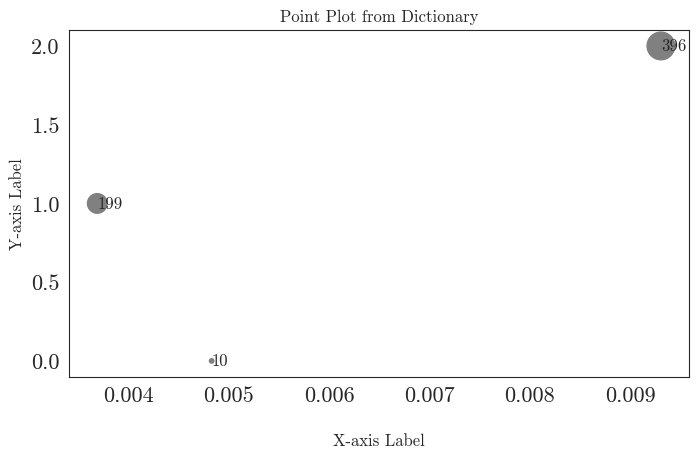

In [17]:
# Plot
plot_param_dicts(thresholds_IC)

### Decaying IC model <a class="anchor" id="decaying-ic-model"></a>

In [18]:
# Simulate
k, threshold, tweet_id, G, n_iter = 0.94, 0.003, pick_random_tweet_id(cascades), create_G(cascades, tweet_id, fn), 5
sim, obs, iterations = sim_decaying_IC(cascades, G, threshold, tweet_id, n_iter = 5, k = k)
print(f'simulated number of retweets: {sim}')
print(f'observed number of retweets: {obs}')

Randomly chosen tweet_id is: '592248921381941248'
simulated number of retweets: 4
observed number of retweets: 9


In [ ]:
# Fit decay parameter
result = fit_decay_param(cascades, n_iter = 5, threshold = 0.00325, fn = fn)

Model mean absolute deviation is: 29.6
Pearson's correlation coefficient: 0.12832642050526863
P-value: 0.001561676321198542


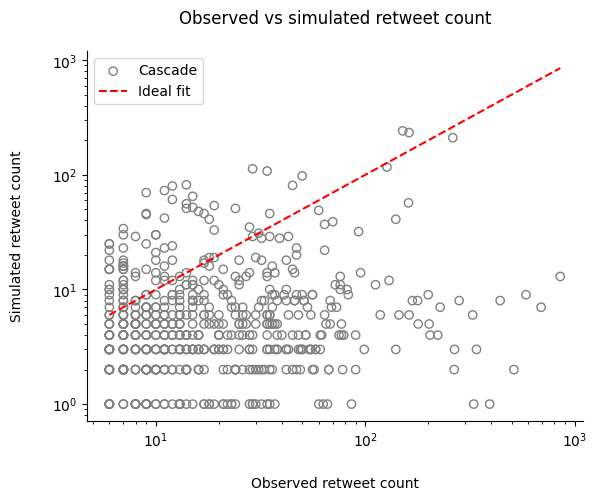

In [3]:
# Evaluate
mad, corr_coef, sims, obss = eval_model(sim_decaying_IC, param = 0.00325, data = cascades, n_iter = 5, fn = fn, k = result.x)

## Time series analysis  <a class="anchor" id="time-series-analysis"></a>

### ECDF <a class="anchor" id="ecdf"></a>

Randomly chosen tweet_id is: '592401666781097984'


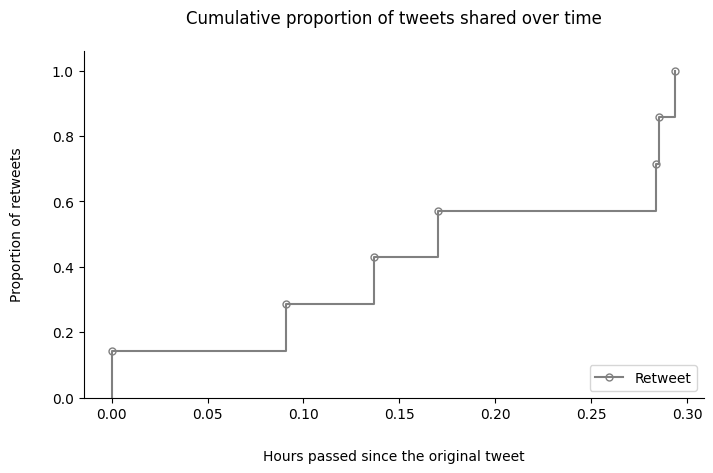

In [14]:
# Plot
tweet_id = pick_random_tweet_id(cascades)
timestamps = cascades.loc[tweet_id].timestamps
plot_timestamps_ecdf(timestamps)

### ECDF vs Decaying IC <a class="anchor" id="ecdf-vs-dec-IC"></a>

In [51]:
# Plot
tweet_ids = cascades.index.values
list_cum_n_rts_scaled = create_list_cum_n_rts(cascades, fn, tweet_ids, jitter_factor = 0)

params = [fit_log_model_iter(sublist) for sublist in list_cum_n_rts_scaled]

# Extract the first and second elements from each ndarray and store them in separate lists
a = np.median([arr[0] for arr in params])
b = np.median([arr[1] for arr in params])

print("Median of the first elements:", a)
print("Median of the second elements:", b)

Median of the first elements: 0.24522812583976053
Median of the second elements: 0.6962597848931587


Randomly chosen tweet_id is: '592203614262665217'
Randomly chosen tweet_id is: '592351505132322819'
Randomly chosen tweet_id is: '591905353845100544'
Randomly chosen tweet_id is: '592266019181240322'
Randomly chosen tweet_id is: '592224880122200065'
Randomly chosen tweet_id is: '592351223988248576'
Randomly chosen tweet_id is: '592205017030995969'
Randomly chosen tweet_id is: '592363682295717888'
Randomly chosen tweet_id is: '592146129409703936'
Randomly chosen tweet_id is: '592284493261602817'
Randomly chosen tweet_id is: '592347512297521152'
Randomly chosen tweet_id is: '592228589606572033'
Randomly chosen tweet_id is: '592251544512299008'
Randomly chosen tweet_id is: '592270063555612672'
Randomly chosen tweet_id is: '592603007444852736'


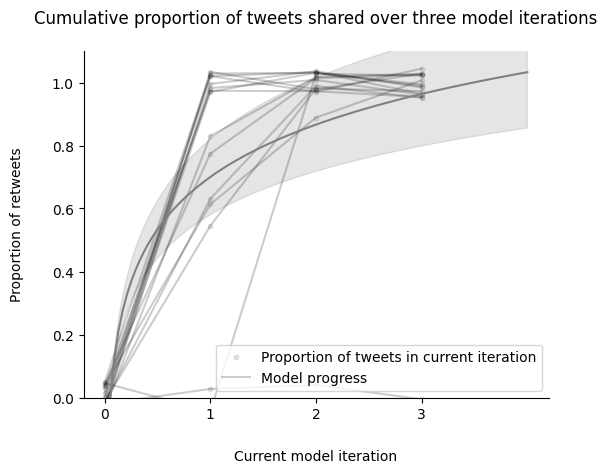

In [11]:
###### Plot model iteration with error band (multiple) ######

# Close, open
plt.close()
plt.figure(figsize=(12/2,9/2))

# Plot
np.random.seed(8)
tweet_ids = pick_n_tweets(cascades, n = 15, seed = 8)
for i in range(15):
    list_cum_n_rts_scaled = create_list_cum_n_rts(cascades, fn, tweet_ids, jitter_factor = 0.05)
    x = [0,1,2,3]
    y = list_cum_n_rts_scaled[i]
    plt.scatter(x, y, alpha=0.1, color = 'black',s=10)
    plt.plot(x, y, linestyle='-', color='black', label='Connected Line', alpha= 0.2)

# Generate x values for log curve
x_values = np.linspace(0.01, 4, 100)  # Avoid log(0) by starting from a small value

# Calculate y values using the log func params
y_values = 0.24 * np.log(x_values) + 0.7

# Plot fitted log curve
plt.plot(x_values, y_values, '-', label='Fitted Logarithmic Curve',color='gray')
    
# Aesthetics
plt.xlabel('Current model iteration',labelpad=20)
plt.ylabel('Proportion of retweets',labelpad=20)
plt.title('Cumulative proportion of tweets shared over three model iterations',pad=20)
plt.legend(['Proportion of tweets in current iteration', 'Model progress'],loc='lower right')
plt.xticks(x) # Make sure x axis is 1,2,3
sns.despine() # Remove the top and right spines for a cleaner appearance


# Error bars
grand_mean_abs_err = calc_grand_mean_abs_err(list_cum_n_rts_scaled)
variance_multiplier = grand_mean_abs_err
variance = variance_multiplier * np.abs(y_values)
plt.fill_between(x_values, y_values - variance, y_values + variance, alpha=0.2, label='Error bands',color = 'Gray')

plt.ylim([0,1.1])

# Save
plt.savefig(fig_path + 'model_iter_band.svg', format='svg', bbox_inches='tight')
plt.savefig(fig_path + 'model_iter_band.png', format='png', bbox_inches='tight', dpi=400)

# Show
plt.show()

### Avrami Equation <a class="anchor" id="avrami-equation"></a>

In [ ]:
# Simulate
t, k, n = 24, 0.005, 2.3
avrami_equation(t, k, n)

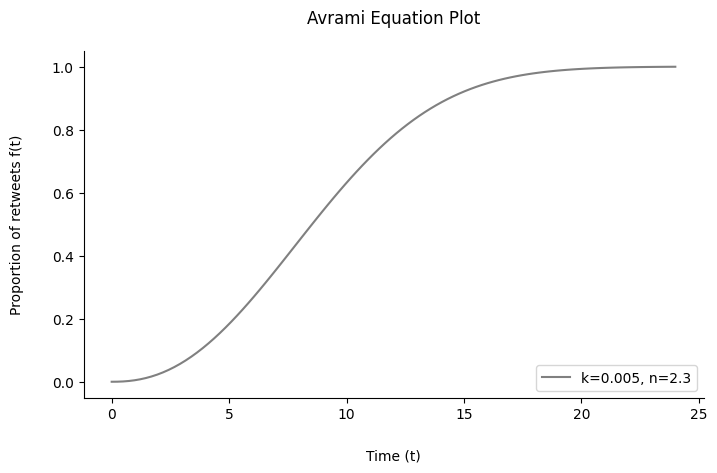

In [13]:
# Plot
plot_avrami_equation(k = k, n = n, t_max = 24)

### Logarithmic fit <a class="anchor" id="log-fit"></a>

In [14]:
# Estimate logarithm function parameters
cascades['log_params'] = cascades.scaled_timestamps.apply(fit_log_model)

a = cascades.log_params.apply(lambda x: x[0]).median() # a = 0.17
b = cascades.log_params.apply(lambda x: x[1]).median() # b = 0.77

print(f'a is: {a}')
print(f'b is: {b}')

a is: 0.1691608246422405
b is: 0.768905966359572


Randomly chosen tweet_id is: '592203614262665217'
Randomly chosen tweet_id is: '592351505132322819'
Randomly chosen tweet_id is: '591905353845100544'
Randomly chosen tweet_id is: '592266019181240322'
Randomly chosen tweet_id is: '592224880122200065'
Randomly chosen tweet_id is: '592351223988248576'
Randomly chosen tweet_id is: '592205017030995969'
Randomly chosen tweet_id is: '592363682295717888'
Randomly chosen tweet_id is: '592146129409703936'
Randomly chosen tweet_id is: '592284493261602817'
Randomly chosen tweet_id is: '592347512297521152'
Randomly chosen tweet_id is: '592228589606572033'
Randomly chosen tweet_id is: '592251544512299008'
Randomly chosen tweet_id is: '592270063555612672'
Randomly chosen tweet_id is: '592603007444852736'


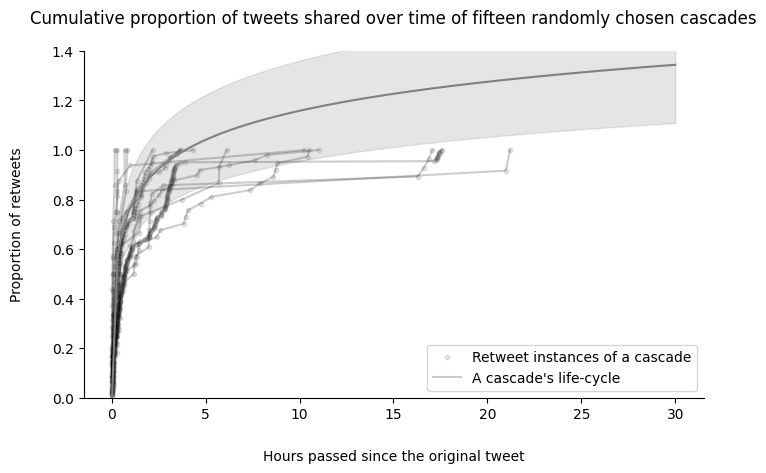

In [12]:
# Plot

# Calculate grand mean absolute error
grand_mean_abs_err = calc_grand_mean_abs_err(list_cum_n_rts_scaled = cascades)

# Generate x values for plotting
x_values = np.linspace(0.01, 30, 100)  # Avoid log(0) by starting from a small value

# Calculate y values for plotting using the logarithmic function
y_values = a * np.log(x_values) + b

plt.close()
plt.figure(figsize=(16/2,9/2))
# Generate and plot scatterplots for 4 random tweet IDs
np.random.seed(8)
for _ in range(15):
    tweet_id = pick_random_tweet_id(cascades)
    x = cascades.loc[tweet_id].scaled_timestamps[1:]
    y = np.linspace(0, 1, len(x)+1)[1:]
    plt.scatter(x, y, label=f'Tweet ID: {tweet_id}', alpha=0.1, color = 'black',s=10)
    plt.plot(x, y, linestyle='-', color='black', label='Connected Line', alpha= 0.2)


filtered_indices = y_values <= 1.05
filtered_x_values = x_values[filtered_indices]
filtered_y_values = y_values[filtered_indices]
    
    
plt.plot(x_values, y_values, '-', label='Fitted Logarithmic Curve',color='gray')
plt.xlabel('Hours passed since the original tweet',labelpad=20)
plt.ylabel('Proportion of retweets',labelpad=20)
plt.title('Cumulative proportion of tweets shared over time of fifteen randomly chosen cascades',pad=20)

plt.legend(['Retweet instances of a cascade', 'A cascade\'s life-cycle'],loc='lower right')
plt.ylim([0,1.4])

# Error bands
variance_multiplier = grand_mean_abs_err
variance = variance_multiplier * np.abs(y_values)
plt.fill_between(x_values, y_values - variance, y_values + variance, alpha=0.2, label='Error bands',color = 'Gray')

# Remove the top and right spines for a cleaner appearance
sns.despine()

# Save
#plt.savefig(fig_path + 'log_plot.svg', format='svg', bbox_inches='tight')
#plt.savefig(fig_path + 'log_plot.png', format='png', bbox_inches='tight', dpi=200)

plt.show()

## Interrater agreement  <a class="anchor" id="interrater-agreement"></a>

### Topic <a class="anchor" id="topic"></a>

In [9]:
# Sample and print 30 tweets
i=1
for tweet in cascades.text.sample(30, random_state = 43):
    print(f'{i}: ')
    print(tweet, "\n")
    i += 1

# Enter your judgments here. These are author's judgments
human_rated = [2, 2, 7, 3, 7, 2, 6, 5, 2, 7, 4, 8, 2, 2, 2, 3, 6, 4, 10, 4, 9, 7, 4, 3, 6, 6, 7, 6, 7, 7]

#
machine_rated = list(cascades.i_topic.sample(30, random_state = 42))
machine_rated = [int(element) for element in machine_rated]

# Compute Cohen's Kappa
kappa = cohen_kappa_score(human_rated, machine_rated)
print(f"Cohen's Kappa: {kappa}")

1: 
@DrGPradhanThis picture shows how  @yogrishiramdev  is helping victims in Nepal #EarthquakeAgain ..#Respect  @DrGPradhan 

2: 
How has the #NepalQuake affected the country's most vulnerable -- its children? I talk to  @unicef_nepal 's Rupa Joshi 5pHKT  @CNNi  #Nepal 

3: 
First IAF plane carrying 3.5 tonnes of relief material and 39 NDRF personnel lands in Kathmandu. #NepalEarthquake 

4: 
JUST IN: Google says one of its engineers killed in Everest avalanche triggered by Nepal quake http://cnb.cx/1delIv5 

5: 
Seeing Nepal disaster feels helpless. But we do only thing I can think of which is donating ( @SavetheChildren ). Every little bit helps. 

6: 
Friends don't donate fund anywhere else except http://PMNRF.GOV.IN as NGO's are using fund for anti national activities. #IndiaWithNepal 

7: 
Here's a collated list of resources, on-ground organizations, helplines etc: http://bit.ly/1HGGMFF #NepalEarthquake  @Netra  please RT 

8: 
Former Indian Cricketer  @VVSLaxman281  praise Modi 

### Semantic category <a class="anchor" id="sem-cat"></a>

In [3]:
print(cascades.topic.value_counts())

i=1
for tweet in cascades.text.sample(30, random_state = 43):
    print(f'{i}: ')
    print(tweet, "\n")
    i += 1

# Enter your judgments here
human_rated = [1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,0,0,1,0, 0, 0,1,0,1,0,0,0,0,0,1,1,0,0,0]
len(human_rated)
# List of GPT model predictions
machine_rated = list(cascades.natures.sample(30, random_state = 43))
machine_rated = [int(element) for element in machine_rated]
machine_rated

# Compute Cohen's Kappa
kappa = cohen_kappa_score(human_rated, machine_rated)
print(f"Cohen's Kappa: {kappa}")

7. Relief efforts, resources, donations, and infrastructure    229
2. Impact, aftermath, death toll                                98
4. International response and international support             79
6. Controversy, criticism, social and political commentary      58
1. Rescue operations and assistance                             30
8. Faith and prayers                                            30
9. Personal experience, stories, and missing people             27
3. Aftershocks and tremors                                      23
5. Technology, communication, and social media                  19
The tweet does not fit any of the given topics.                 12
Name: topic, dtype: int64
1: 
@DrGPradhanThis picture shows how  @yogrishiramdev  is helping victims in Nepal #EarthquakeAgain ..#Respect  @DrGPradhan 

2: 
How has the #NepalQuake affected the country's most vulnerable -- its children? I talk to  @unicef_nepal 's Rupa Joshi 5pHKT  @CNNi  #Nepal 

3: 
First IAF plane carrying 3.